In [199]:

import pandas as pd

import io
import os

import numpy as np

import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px

import requests
import lxml
import html5lib

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from scipy.spatial.distance import cdist
from bmdcluster import blockdiagonalBMD
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
directory_path = os.getcwd()
if not os.path.exists(directory_path+'//Результаты'):
    os.makedirs('Результаты')

In [ ]:
bond_url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'

In [ ]:
req = requests.get(bond_url).content
raw_data = pd.read_csv(io.StringIO(req.decode('cp1251')), sep=';', header= 1)

In [ ]:
### Предобработка
print('Форма данных:', raw_data.shape[0], 'строк и',raw_data.shape[1],'полей')

In [ ]:
raw_data.info(verbose = True)

In [ ]:
# Пропущенные наблюдения
raw_data.isna().sum().sort_values(ascending = False).head(10)

In [ ]:
# Ищем дубликаты
print(f'Дубликаты: {raw_data.iloc[:,1:].duplicated().sum()}, ({np.round(100*raw_data.iloc[:,1:].duplicated().sum()/len(raw_data),1)}%)')

In [ ]:
### Исправляем данные

## str, object -> float
# Значение купона должно быть числовым с точкой (float), в наборе данных - str. Из-за запятой

raw_data['COUPONPERCENT'] = raw_data['COUPONPERCENT'].str.replace(',','.').apply(float)
raw_data['COUPONPERCENT'].describe

# FACEVALUE
raw_data['FACEVALUE'] = raw_data['FACEVALUE'].str.replace(',','.').apply(float)
raw_data['FACEVALUE'].describe
# INITIALFACEVALUE
raw_data['INITIALFACEVALUE'] = raw_data['INITIALFACEVALUE'].str.replace(',','.').apply(float)
raw_data['INITIALFACEVALUE'].describe
# PRICE
raw_data['PRICE'] = raw_data['PRICE'].str.replace(',','.').apply(float)
raw_data['PRICE'].describe
# PRICE_RUB
raw_data['PRICE_RUB'] = raw_data['PRICE_RUB'].str.replace(',','.').apply(float)
raw_data['PRICE_RUB'].describe
# COUPONVALUE
raw_data['COUPONVALUE'] = raw_data['COUPONVALUE'].str.replace(',','.').apply(float)
raw_data['COUPONVALUE'].describe


## str, object -> datetime

# ISSUEDATE
raw_data['ISSUEDATE'] = pd.to_datetime(raw_data['ISSUEDATE'],format='%d.%m.%Y')
raw_data['COUPONDATE'] = pd.to_datetime(raw_data['COUPONDATE'],format='%d.%m.%Y')
raw_data['OFFERDATE'] = pd.to_datetime(raw_data['OFFERDATE'],format='%Y-%m-%d')
raw_data['MATDATE'] = pd.to_datetime(raw_data['MATDATE'],format='%d.%m.%Y')
# STARTDATEMOEX # есть пропуски
raw_data['STARTDATEMOEX'] = pd.to_datetime(raw_data['STARTDATEMOEX'],format='%Y-%m-%d')

In [ ]:
### Первый подход к расчёту доходности
new_data = raw_data.copy()
print('До очистки',new_data.shape)
### Заполнение логических пропусков
new_data['COUPONLENGTH'].fillna(np.divide(365,new_data['COUPONFREQUENCY']),inplace = True)
new_data['COUPONFREQUENCY'].fillna(np.divide(365,new_data['COUPONLENGTH']),inplace = True)
new_data['COUPONVALUE'].fillna(new_data['COUPONPERCENT']*new_data['FACEVALUE']/100, inplace = True)
new_data = new_data.dropna(subset = ['COUPONVALUE','COUPONDAYSPASSED','COUPONLENGTH','PRICE','FACEVALUE','SECID','COUPONDATE','COUPONDAYSREMAIN','MATDATE','ISSUEDATE'])
print('После очистки', new_data.shape)
new_data['НКД'] = new_data['COUPONVALUE']*(np.divide(new_data['COUPONDAYSPASSED'],new_data['COUPONLENGTH']))
new_data['Годовой доход'] = (new_data['COUPONVALUE']*new_data['COUPONFREQUENCY'])*100 # в процентных пунктах!
new_data['Рыночная цена'] = new_data['PRICE']/100*new_data['FACEVALUE']
new_data[['ISIN','PRICE','FACEVALUE','COUPONDATE','COUPONDAYSPASSED','COUPONDAYSREMAIN']].head()
# Найдём исходную дату запроса - на случай технических проблем
check_date = ((new_data['COUPONDATE'][0])-datetime.timedelta(days=new_data['COUPONDAYSREMAIN'][0]))
# Нужно найти дату погашения или дату ближайшей оферты - смотря что ближе
for i in new_data.index:
    if new_data.loc[i,'OFFERDATE'] < new_data.loc[i,'MATDATE']:
        new_data.loc[i, 'Финальная дата'] = new_data.loc[i,'OFFERDATE']
    else:
        new_data.loc[i,'Финальная дата'] = new_data.loc[i,'MATDATE']


new_data['N оставшихся купонов'] = np.floor(np.divide((new_data['Финальная дата'] - check_date).astype('timedelta64[D]'),new_data['COUPONLENGTH']))
new_data['Валютный риск'] = 0

for i in new_data.index:
    if new_data.loc[i,'FACEUNIT'] != 'RUB':
        new_data.loc[i, 'Валютный риск'] = 1
new_data['Годовой купон в %'] = (new_data['COUPONVALUE']*(new_data['COUPONFREQUENCY']))/(new_data['FACEVALUE'])*100 # в процентных пунктах!
new_data['Лет до погашения'] = (new_data['Финальная дата'] - check_date).astype('timedelta64[M]')/12
new_data['Срочность инструмента'] = (new_data['Финальная дата'] - new_data['ISSUEDATE']).astype('timedelta64[M]')/12
new_data = new_data[new_data['Финальная дата'] >= check_date]
new_data['Период НКД'] = new_data['COUPONDAYSPASSED']/new_data['COUPONLENGTH']
new_data['Переоценка в %'] = 100*(new_data['Рыночная цена']-new_data['FACEVALUE'])/new_data['FACEVALUE']
new_data['IS_RII'].replace('R',1,inplace = True)
new_data['IS_RII'].fillna(0,inplace = True)

In [ ]:
### Пишем функцию для расчёта доходности
# https://journal.open-broker.ru/investments/formula-dlya-rascheta-dohodnosti-obligacij-k-pogasheniyu/
### входные параметры:
# df
# nkd_col - поле с накопленным купонным доходом в dataframe, в абсолютном выражении
# coup_val_col - поле с купонными доходами в абсолютном выражении
# market_price_col - поле с текущей рыночной ценой облигации, в абсолютном выражении
# nom_col - поле со значением номинала, в абсолютном выражении
# broker_fee_rate - ставка комиссии брокера, в процентах
# ex_fee_rate  - ставка комиссии биржи, в процентах
# tax_rate - ставка налога, в десятичных долях
# coupons_n_col - количество оставшихся купонов, в штуках
# final_date_col - дата оферты или погашения бумаги
def calc_bond_yield(
    df,
    nkd_col,
    coup_val_col,
    market_price_col,
    nom_col,
    coupons_n_col,
    broker_fee_rate,
    ex_fee_rate,
    tax_rate,
    final_date_col,
    check_date
    ):
    df['REALBONDYIELD'] = 0
    for i in df.index:
        if (df.loc[i,nom_col]>df.loc[i,market_price_col]):
            df.loc[i,'REALBONDYIELD'] = 100*np.divide(np.divide(((
                df.loc[i, nom_col] - df.loc[i, market_price_col])*(1-tax_rate) - df.loc[i,nkd_col] + (
                (1-tax_rate)*df.loc[i,coup_val_col]*(df.loc[i,coupons_n_col])    
                )),(
                    df.loc[i,market_price_col]+df.loc[i,nkd_col])*(1+broker_fee_rate/100+ex_fee_rate/100
                )),(df.loc[i,final_date_col] - check_date).days/365)
        else:
            df.loc[i,'REALBONDYIELD'] = 100*np.divide(np.divide(((
                df.loc[i, nom_col] - df.loc[i, market_price_col]) - df.loc[i,nkd_col] + (
                (1-tax_rate)*df.loc[i,coup_val_col]*df.loc[i,coupons_n_col]    
                )),(
                    df.loc[i,market_price_col]+df.loc[i,nkd_col])*(1+(broker_fee_rate/100)+(ex_fee_rate/100)
                )),(df.loc[i,final_date_col] - check_date).days/365)

In [ ]:
calc_bond_yield(
    df = new_data, 
    nkd_col = 'НКД',
    coup_val_col = 'COUPONVALUE',
    market_price_col = 'Рыночная цена',
    nom_col = 'FACEVALUE',
    coupons_n_col = 'N оставшихся купонов',
    broker_fee_rate = 0.06,
    ex_fee_rate = 0.0125,
    tax_rate = 0.13,
    final_date_col = 'Финальная дата',
    check_date = check_date
    )


In [ ]:
### Добавляем КБД
url = ('http://iss.moex.com/iss/engines/stock/zcyc.csv?iss.only=yearyields')

zcyc_data = requests.get(url).content
zcyc_data = pd.read_csv(io.StringIO(zcyc_data.decode('UTF-8')), sep = ';', header= 1)
zcyc_data.columns = ['Дата записи','Контрольное время', 'Срочность', 'Значение КБД']
print(zcyc_data)

plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'])
plt.title('Кривая бескупонной доходности')
plt.ylabel('Процентные пункты')
plt.xlabel('Лет до погашения, в годах')

In [ ]:
def zcyc_match(df,zcyc_df, mat_column):
    for i in df.index:
        for j in range(len(zcyc_df)-1):
            if (df.loc[i,mat_column] > zcyc_df.loc[j,'Срочность']) & (df.loc[i,mat_column] <= zcyc_df.loc[j+1,'Срочность']):
                df.loc[i,'КБД'] = zcyc_df.loc[j,'Значение КБД']

In [ ]:
zcyc_match(new_data,zcyc_data,'Лет до погашения')
new_data['Риск-премия'] = new_data['REALBONDYIELD'] - new_data['КБД']

In [ ]:
new_data['TYPENAME'].value_counts()

In [ ]:
new_data['FACEUNIT'].value_counts()

In [ ]:
# На какой срок выпускали бумаги?
print(new_data['Срочность инструмента'].describe())
fig = sns.histplot(new_data, x = 'Срочность инструмента', kde = True)
plt.title('Срочность облигаций')
plt.xlabel('Лет до погашения при эмиссии, в годах')
plt.ylabel('N выпусков')


In [ ]:
# Сколько осталось до погашения?
print(new_data['Лет до погашения'].describe())
fig = sns.histplot(new_data, x = 'Лет до погашения', kde = True)
plt.title('Распределение остатка срока')
plt.xlabel('Лет до погашения, в годах')
plt.ylabel('N выпусков')


In [ ]:
# Как распределена Годовой купон в %?
fig = sns.histplot(new_data, x = 'Годовой купон в %', kde = True)
plt.title('Распределение годовой купонной доходности')
plt.xlabel('Доходность, в %')
plt.ylabel('N выпусков')
print(new_data['Годовой купон в %'].describe())

In [ ]:
# Распределение облигаций по доходности и сроку погашения

sns.scatterplot(data = new_data, 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME')

In [ ]:
# RUB облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'RUB'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.ylabel('Доходность в %')
plt.xlabel('Лет до погашения, в годах')
plt.title('Купонная доходность RUB облигаций')
plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'], color = 'b', label = 'КБД')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'RUB'][['Годовой купон в %','Лет до погашения']].describe())

In [ ]:
# Долларовые облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'USD'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность USD облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'USD'][['Годовой купон в %','Лет до погашения']].describe())

In [ ]:
# Евро облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'EUR'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность EUR облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'EUR'][['Годовой купон в %','Лет до погашения']].describe())

In [ ]:
# CHF облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'CHF'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность CHF облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'CHF'][['Годовой купон в %','Лет до погашения']].describe())

In [ ]:
# GBP облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'GBP'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность GBP облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'GBP'][['Годовой купон в %','Лет до погашения']].describe())

In [ ]:
# CNY облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'CNY'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность CNY облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'CNY'][['Годовой купон в %','Лет до погашения']].describe())

In [ ]:
pd.pivot_table(new_data, values = 'SECID', index = 'TYPENAME', columns = 'FACEUNIT', aggfunc = 'count')

In [ ]:
### Ищем кластеры - по валютам!
clusters_data = new_data[['SECID','LISTLEVEL','HIGH_RISK','IS_RII','Годовой купон в %','N оставшихся купонов','Лет до погашения','Срочность инструмента','Переоценка в %','REALBONDYIELD','Риск-премия']][new_data['FACEUNIT'] == 'RUB']
clusters_data = clusters_data.set_index('SECID')
clusters_data.dropna(inplace= True)

spectral_cluster_model = SpectralClustering(
    n_clusters = 3,
    random_state= 1481,
    n_neighbors= 10,
    affinity = 'nearest_neighbors'
)
clusters_data['Кластер'] = spectral_cluster_model.fit_predict(clusters_data[['LISTLEVEL','HIGH_RISK','IS_RII','Годовой купон в %','N оставшихся купонов','Лет до погашения','Срочность инструмента','Переоценка в %','REALBONDYIELD','Риск-премия']])
fig, ax = plt.subplots()
sns.scatterplot(x='Лет до погашения', y='Годовой купон в %', data=clusters_data, hue='Кластер', ax=ax)
ax.set(title='Спектральные кластеры')

In [198]:
clusters_data.isna().sum()

LISTLEVEL                0
HIGH_RISK                0
IS_RII                   0
Годовой купон в %        0
N оставшихся купонов     0
Лет до погашения         0
Срочность инструмента    0
Переоценка в %           0
REALBONDYIELD            0
Риск-премия              0
Кластер                  0
dtype: int64

For n_clusters = 2 The average silhouette_score is : 0.985111273490636
For n_clusters = 3 The average silhouette_score is : 0.9669000367129073
For n_clusters = 4 The average silhouette_score is : 0.9636734071605054
For n_clusters = 5 The average silhouette_score is : 0.7389117300529804
For n_clusters = 6 The average silhouette_score is : 0.7456167937652944
For n_clusters = 7 The average silhouette_score is : 0.7404732244469575
For n_clusters = 8 The average silhouette_score is : 0.41836151012971323
For n_clusters = 9 The average silhouette_score is : 0.4202067531669428
For n_clusters = 10 The average silhouette_score is : 0.4204808259906699


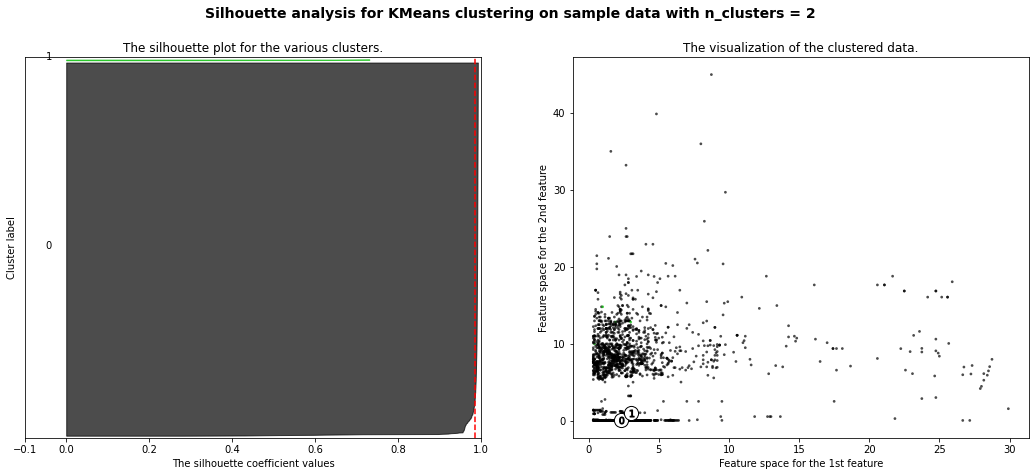

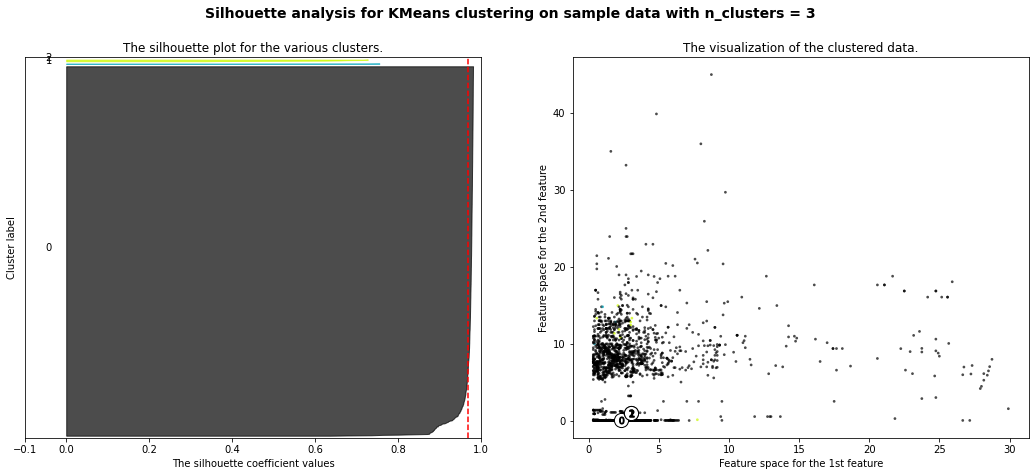

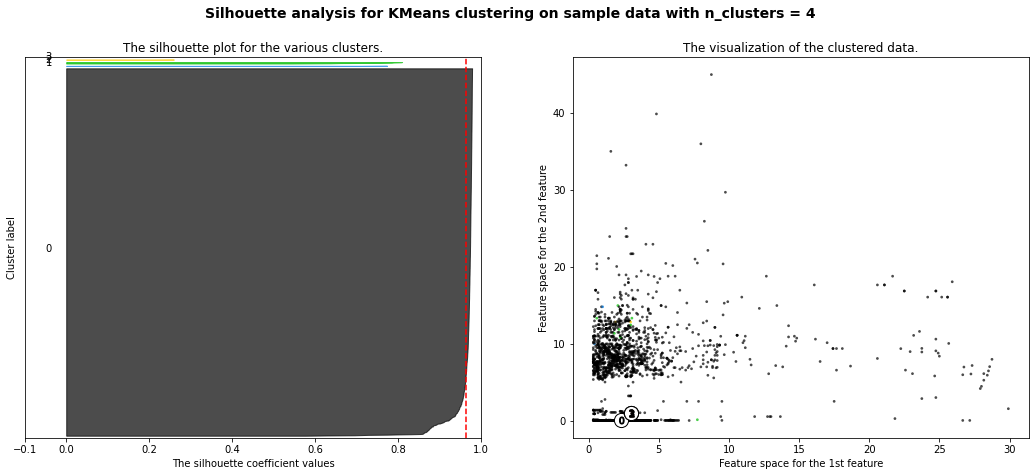

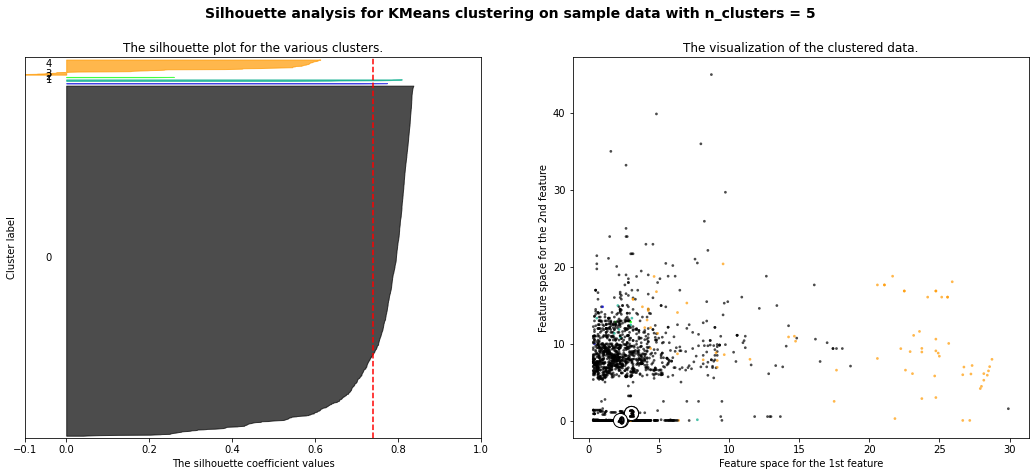

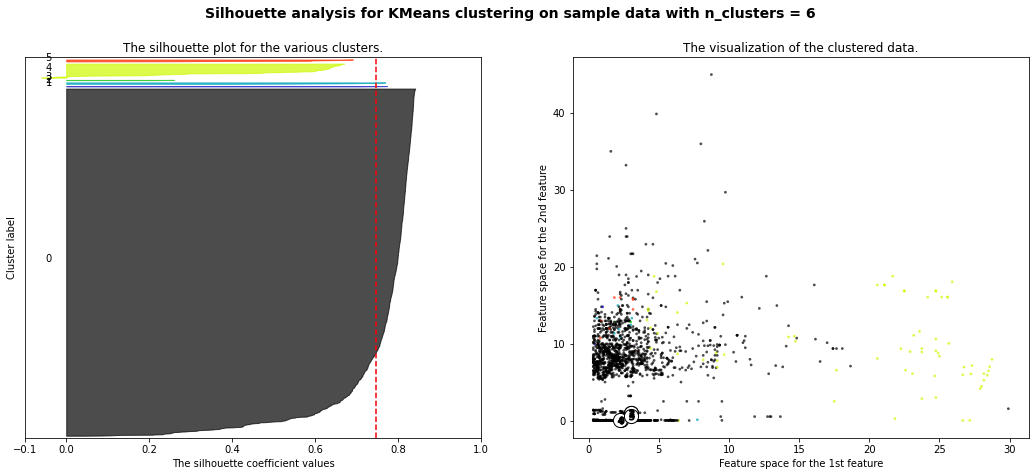

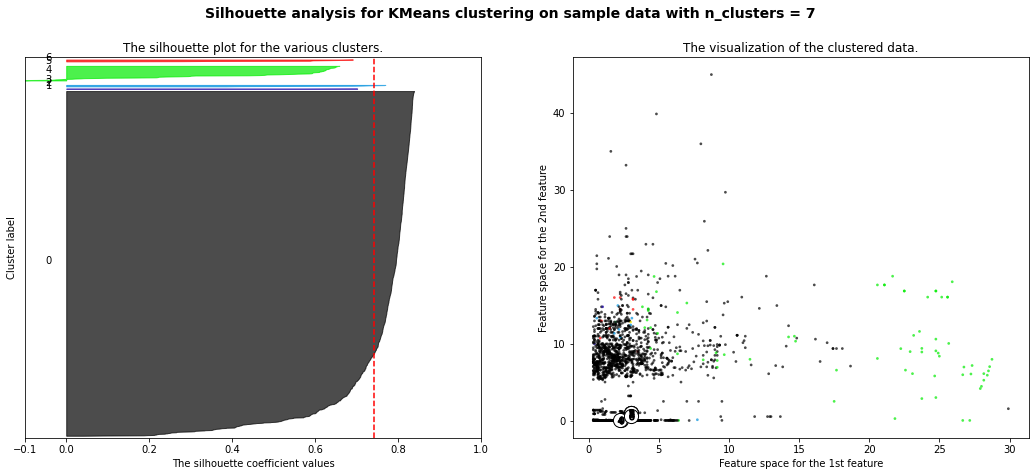

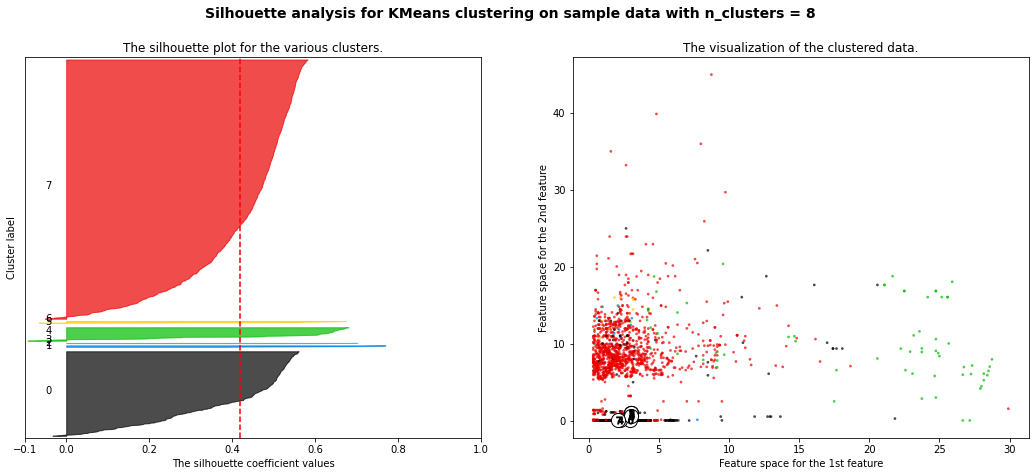

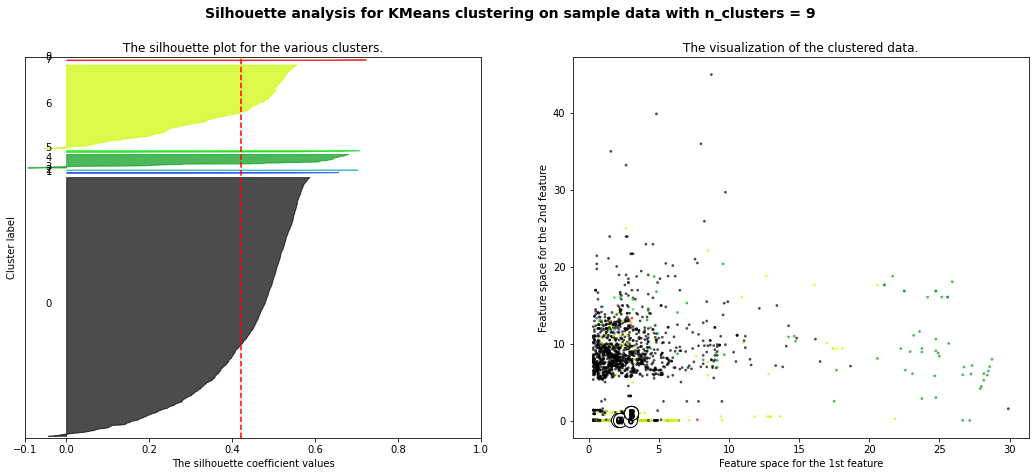

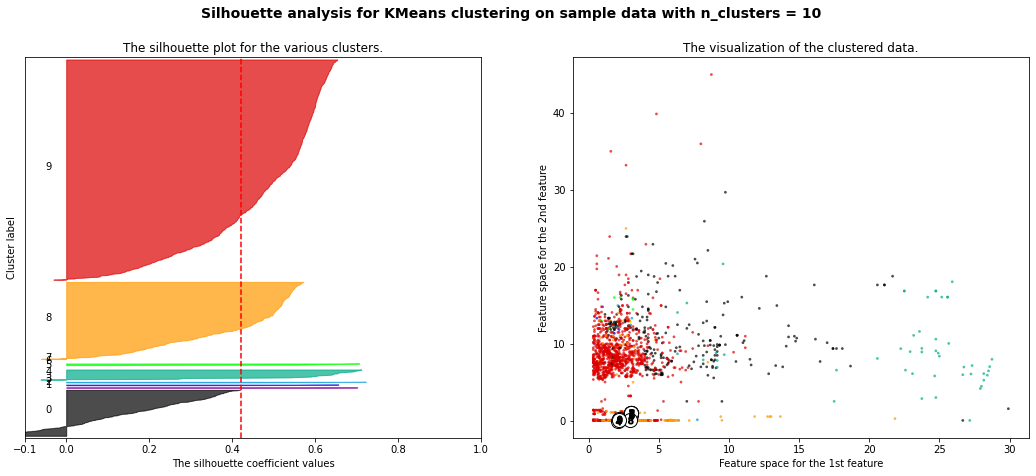

In [205]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(clusters_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(clusters_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(clusters_data, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(clusters_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        clusters_data.loc[:, 'Лет до погашения'], clusters_data.loc[:, 'Годовой купон в %'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [210]:
from OptimalCluster.opticlust import Optimal
opt = Optimal()
opt_sil_value = opt.silhouette(clusters_data)

Optimal number of clusters is:  2


c:\Users\mikha\AppData\Local\Programs\Python\Python38\lib\site-packages\OptimalCluster\opticlust.py:825: UserWarning: Many cases to check, may take some time
  warnings.warn('Many cases to check, may take some time')


AttributeError: 'NoneType' object has no attribute 'split'

Часть вторая: отбор оптимальных облигаций

In [ ]:
### Отбираем низкий риск
## Первый котировальный список
## Валюта - строго RUB
## SECSUBTYPE - пропуск, т.к. сложные продукты
## HIGH_RISK == 0
## IS_QUALIFIED_INVESTORS == 0
## Премия от КБД > 0 и < 5 п.п.

final_data = new_data[new_data['Период НКД'] >= 0.2]
final_data = final_data[
    (new_data['LISTLEVEL'] == 1)&
    (new_data['FACEUNIT']=='RUB')&
    (new_data['HIGH_RISK']==0)&
    (new_data['SECSUBTYPE'].isna())&
    (new_data['IS_QUALIFIED_INVESTORS'] == 0)&
    (new_data['REALBONDYIELD']>0)&
    (abs(new_data['Переоценка в %'])<=10)&
    (new_data['Риск-премия']>0)&
    (new_data['Риск-премия']<0.5*new_data['КБД'])]
final_data = final_data[['SECID','TYPENAME','Лет до погашения','REALBONDYIELD','Финальная дата','FACEVALUE','Рыночная цена','Переоценка в %','COUPONVALUE','Годовой купон в %','НКД','КБД','Риск-премия']]
final_data.sort_values(by = 'REALBONDYIELD',ascending=False).head(10)

In [ ]:
sns.relplot(data = final_data, 
x = 'Лет до погашения', 
y = 'REALBONDYIELD',
hue = 'TYPENAME',
legend = 'full'
)
plt.ylabel('Реальная доходность в %')
plt.xlabel('Лет до погашения, в годах')
plt.title('Множество отобранных облигаций')
plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'], color = 'b', label = 'КБД')
plt.show()
print(final_data[['REALBONDYIELD','Лет до погашения']].describe())

In [ ]:
top_10_bonds = final_data.sort_values(by = 'REALBONDYIELD',ascending=False).head(10)
top_10_bonds

In [ ]:
top_1q_bonds = final_data[final_data['Лет до погашения'] <= 0.25]
top_h_bonds = final_data[(final_data['Лет до погашения'] <= 0.5)&(final_data['Лет до погашения'] > 0.25)]
top_3q_bonds = final_data[(final_data['Лет до погашения'] <= 0.75)&(final_data['Лет до погашения'] > 0.5)]
top_1y_bonds = final_data[(final_data['Лет до погашения'] <= 1)&(final_data['Лет до погашения'] > 0.75)]
top_2y_bonds = final_data[(final_data['Лет до погашения'] <= 2)&(final_data['Лет до погашения'] > 1)]
top_3y_bonds = final_data[(final_data['Лет до погашения'] <= 3)&(final_data['Лет до погашения'] > 2)]
top_5y_bonds = final_data[(final_data['Лет до погашения'] <= 5)&(final_data['Лет до погашения'] > 3)]
top_7y_bonds = final_data[(final_data['Лет до погашения'] <= 7)&(final_data['Лет до погашения'] > 5)]
top_10y_bonds = final_data[(final_data['Лет до погашения'] <= 10)&(final_data['Лет до погашения'] > 7)]
top_15y_bonds = final_data[(final_data['Лет до погашения'] <= 15)&(final_data['Лет до погашения'] > 10)]
top_20y_bonds = final_data[(final_data['Лет до погашения'] <= 20)&(final_data['Лет до погашения'] > 15)]
top_30y_bonds = final_data[(final_data['Лет до погашения'] <= 30)&(final_data['Лет до погашения'] > 20)]

In [ ]:

from time import strftime


with pd.ExcelWriter(directory_path+'\\'+r'Результаты'+'\\Анализ облигаций РМА ' + datetime.datetime.now().strftime('%Y %m %d %H-%M-%S') +  '.xlsx', mode='w') as writer:    
    final_data.to_excel(writer, sheet_name = 'Выборка', index = False)
    zcyc_data.to_excel(writer, sheet_name = 'КБД', index = False)
    top_h_bonds.to_excel(writer, sheet_name='До 6 м', index = False)
    top_3q_bonds.to_excel(writer, sheet_name='До 9 м', index = False)
    top_1y_bonds.to_excel(writer, sheet_name='До 1 г', index = False)
    top_2y_bonds.to_excel(writer, sheet_name='До 2 л', index = False)
    top_3y_bonds.to_excel(writer, sheet_name='До 3 л', index = False)
